# README

In this workbook, our goal is to experiment with some non-correlation based similarity metrics to more clearly present the differences between reddit and twitter results. We'll use the 'raw results' from Peter.

In [1]:
from collections import defaultdict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#twitter = np.load('raw_results/twitter_axes.npy'  , allow_pickle=True)
twitter = np.load('raw_results/twitter_axes-3.npy'  , allow_pickle=True)
reddit  = np.load('raw_results/reddit_axes(3).npy', allow_pickle=True)

loading instructions from peter:
```
ax_id = 0 # linguistic complexity
exp_id = 1 # +sick
model = 'Logistic_Regression_counts'
metric = 'ATE_strat_gt' # MUST INCLUDE gt (this means no bootstrap)
axes_reddit[ax_id]['experiments'][exp_id]['results_dict'][model][metric]
```

In [4]:
# models: 'avgBERT', 'Logistic_Regression_(1gram)', 'oracle', 'Logistic_Regression_counts', 'Logistic_Regression', 'Simple_NN', 'Simple_NN_counts', 'Logistic_Regression_LDA', 'Simple_NN_(1gram)', 'HBERT', 'Simple_NN_LDA'

# metrics: 'test_acc_gt', 'bias_strat_gt', 'bias_ipw_gt', 'ATE_strat_gt', 'ATE_ipw_gt', 'brier_gt', 'inv_brier_gt', 'spearman_gt', 'mse_ipsw_gt'


#   # task              # level                # model  # metric
reddit[0]['experiments'][0]['results_dict']['HBERT']['test_acc_gt']

0.8935

In [5]:
task_id = {
#                                     (index, # levels) 
    'Linguistic Complexity'         : (0, 4),
    'Signal Intensity'              : (1, 2),
    'Order of Text'                 : (2, 2),
    'Strength of Selection Effect'  : (3, 2),
    'Sample Size'                   : (4, 3),
    'Placebo Test'                  : (5, 1),
}

In [6]:
#tasks_to_include  = list(task_id.keys())
tasks_to_include  = ['Linguistic Complexity', 'Signal Intensity', 'Strength of Selection Effect', 'Sample Size', 'Placebo Test'] 
models_to_include = ['Logistic_Regression_(1gram)', 'Logistic_Regression_counts', 'Logistic_Regression', 'Simple_NN', 'Simple_NN_counts', 'Logistic_Regression_LDA', 'Simple_NN_(1gram)', 'HBERT', 'Simple_NN_LDA']
metric            = 'test_acc_gt'

In [7]:
def flatten(data, metric, tasks_to_include=tasks_to_include, models_to_include=models_to_include):
    out = []
    for task in tasks_to_include:
        for level in range(task_id[task][1]): # num levels
            for model in models_to_include:
                out.append( data[task_id[task][0]]['experiments'][level]['results_dict'][model][metric] )
    return pd.Series(out)

In [8]:
flatten(reddit, metric='test_acc_gt').corr( flatten(twitter, metric='test_acc_gt'), method='pearson' )

0.9565555195202075

# suggestions from tim:

- max difference between any values “in the bucket”, max(twitter - reddit)
- Mean absolute difference
- RMSE


In [9]:
t = flatten(twitter, metric='test_acc_gt')
r = flatten(reddit,  metric='test_acc_gt')

In [10]:
np.mean( np.abs(t-r) )

0.01947222222222221

In [11]:
mean_ad_l    = {}
mean_ratio_l = {}
pearson_l    = {}

print(f"{'METRIC':<30} {'MEAN AD':>8} {'MAX AD':>8} {'RMSE':>8} {'M RATIO':>8} | {'PEARSON':>8} {'SPEARMAN':>8}")

# for metric, metric_name in [('test_acc_gt', 'Test Accuracy'), ('ATE_ipw_gt', 'ATE (IPTW)'), ('ATE_strat_gt', 'ATE (Stratified)')]:
for metric, metric_name in [('test_acc_gt', 'Test Accuracy'), ('bias_strat_gt', 'Bias (Stratified)'), ('bias_ipw_gt', 'Bias (IPTW)'), ('ATE_strat_gt', 'ATE (Stratified)'), ('ATE_ipw_gt', 'ATE (IPTW)')]:
    
    t = flatten(twitter, metric=metric)
    r = flatten(reddit,  metric=metric)
    
    pearson  = t.corr( r, method='pearson'  )
    spearman = t.corr( r, method='spearman' )
    
    mad  = np.mean( np.abs(   t-r) )     # mean absolute difference
    maxd = max(     np.abs(   t-r) )     # max absolute difference
    rmse = np.sqrt( np.mean( (t-r)**2 )) # root mean square error
    
#     ratio = np.mean( np.minimum(r, t) / np.maximum(r, t) ) # mean ratio of min:max
    ratio = np.mean( t/r ) # mean ratio twitter:reddit
    
    mean_ad_l   [metric_name] = mad
    mean_ratio_l[metric_name] = ratio
    pearson_l   [metric_name] = pearson
    
    
    print(f"{metric_name:<30} {mad:8.3f} {maxd:8.3f} {rmse:8.3f} {ratio:8.3f} | {pearson:8.3f} {spearman:8.3f}")

METRIC                          MEAN AD   MAX AD     RMSE  M RATIO |  PEARSON SPEARMAN
Test Accuracy                     0.019    0.302    0.040    1.006 |    0.957    0.935
Bias (Stratified)                 0.032    0.214    0.043    1.015 |    0.930    0.914
Bias (IPTW)                       0.052    0.212    0.071    0.448 |    0.842    0.889
ATE (Stratified)                  0.032    0.214    0.043    1.042 |    0.946    0.930
ATE (IPTW)                        0.052    0.212    0.071    1.157 |    0.887    0.907


In [12]:
overall_results = pd.DataFrame([mean_ad_l, mean_ratio_l, pearson_l], index=['Mean Absolute Difference', 'Mean Twitter:Reddit Ratio', "Pearson's r"]).transpose()
overall_results.drop([r for r in overall_results.index if 'Bias' in r], inplace=True)
overall_results

,Mean Absolute Difference,Mean Twitter:Reddit Ratio,Pearson's r
Test Accuracy,0.019472,1.005533,0.956556
ATE (Stratified),0.031951,1.041795,0.946178
ATE (IPTW),0.052112,1.157428,0.886919


In [13]:
print( overall_results.round(3).to_latex(bold_rows=True, column_format='l|rrr') )

\begin{tabular}{l|rrr}
\toprule
{} &  Mean Absolute Difference &  Mean Twitter:Reddit Ratio &  Pearson's r \\
\midrule
\textbf{Test Accuracy   } &                     0.019 &                      1.006 &        0.957 \\
\textbf{ATE (Stratified)} &                     0.032 &                      1.042 &        0.946 \\
\textbf{ATE (IPTW)      } &                     0.052 &                      1.157 &        0.887 \\
\bottomrule
\end{tabular}



# discrete plots

In [14]:
metric_names_pretty = {
    'test_acc_gt'    : 'Treatment Accuracy',
#     'bias_ipw_gt'    : 'Bias of ATE\n(IPTW)',
#     'bias_strat_gt'  : 'Bias of ATE\n(Stratified)',
    'ATE_ipw_gt'     : 'ATE (IPTW)',
    'ATE_strat_gt'   : 'ATE\n(Stratified)',
}

In [15]:
model_names_pretty = {
    'Logistic_Regression_(1gram)' : 'Logistic Regression\n(1-grams)',
    'Simple_NN_(1gram)'           : 'Simple NN\n(1-grams)',
    'Logistic_Regression'         : 'Logistic Regression\n(1,2-grams)',
    'Simple_NN'                   : 'Simple NN\n(1,2-grams)',
    'Logistic_Regression_counts'  : 'Logistic Regression\n(1,2-grams, counted)',
    'Simple_NN_counts'            : 'Simple NN\n(1,2-grams, counted)',
    'Logistic_Regression_LDA'     : 'Logistic Regression\n(LDA features)',
    'Simple_NN_LDA'               : 'Simple NN\n(LDA features)',
    'HBERT'                       : 'SHERBERT',
#     'oracle'                      : 'Oracle Propensity',
}

In [16]:
tasks_to_include  = ['Linguistic Complexity',
                     'Signal Intensity',
                     'Strength of Selection Effect',
                     'Sample Size',
                     'Placebo Test',
                    ] 

In [17]:
func, agg_func, func_name, color_config = (lambda r, t: np.abs( t-r)), np.mean, "Mean Absolute Difference", {'cmap':'Reds', 'vmin':0, 'vmax':1}

# func, agg_func, func_name, color_config = (lambda r, t: np.abs( t-r)), np.median, "Median Absolute Difference", {'cmap':'Reds', 'vmin':0, 'vmax':1}

# func, agg_func, func_name, color_config = (lambda r, t: t/r),          np.mean, "Mean T:R Ratio",           {'cmap':'bwr', 'vmin':0, 'vmax':2, 'center':1}

In [18]:
# models
models_range = defaultdict(list)
models_n     = defaultdict(list)
models_sim   = defaultdict(list)

for metric, metric_name in metric_names_pretty.items():
    for model, model_name in list(model_names_pretty.items())+[(model_names_pretty.keys(), 'Overall')]:
        t = flatten(twitter, metric=metric, tasks_to_include=tasks_to_include, models_to_include=[model] if type(model) is str else model)
        r = flatten(reddit,  metric=metric, tasks_to_include=tasks_to_include, models_to_include=[model] if type(model) is str else model)
        
        result = func(r, t)

        models_range[metric_name].append( max(result)-min(result) )
        models_n    [metric_name].append( len(result)             )
        models_sim  [metric_name].append( agg_func(result)        )
        
models_range = pd.DataFrame(models_range, index=list(model_names_pretty.values()) + ['Overall'])
models_n     = pd.DataFrame(models_n,     index=list(model_names_pretty.values()) + ['Overall'])
models_sim   = pd.DataFrame(models_sim,   index=list(model_names_pretty.values()) + ['Overall'])

models_sim.index.name = 'Representation and Model'

In [19]:
# tasks
tasks_range = defaultdict(list)
tasks_n     = defaultdict(list)
tasks_sim   = defaultdict(list)

for metric, metric_name in metric_names_pretty.items():
    for task in tasks_to_include + ['Overall']:       
        t = flatten(twitter, metric=metric, tasks_to_include=[task] if task!='Overall' else tasks_to_include, models_to_include=model_names_pretty.keys())
        r = flatten(reddit,  metric=metric, tasks_to_include=[task] if task!='Overall' else tasks_to_include, models_to_include=model_names_pretty.keys())
        
        result = func(r, t)

        tasks_range[metric_name].append( max(result)-min(result) )
        tasks_n    [metric_name].append( len(result)             )
        tasks_sim  [metric_name].append( agg_func(result)        )
        
tasks_range = pd.DataFrame(tasks_range, index=tasks_to_include + ['Overall'])
tasks_n     = pd.DataFrame(tasks_n,     index=tasks_to_include + ['Overall'])
tasks_sim   = pd.DataFrame(tasks_sim,   index=tasks_to_include + ['Overall'])

tasks_sim.index.name = 'Task'

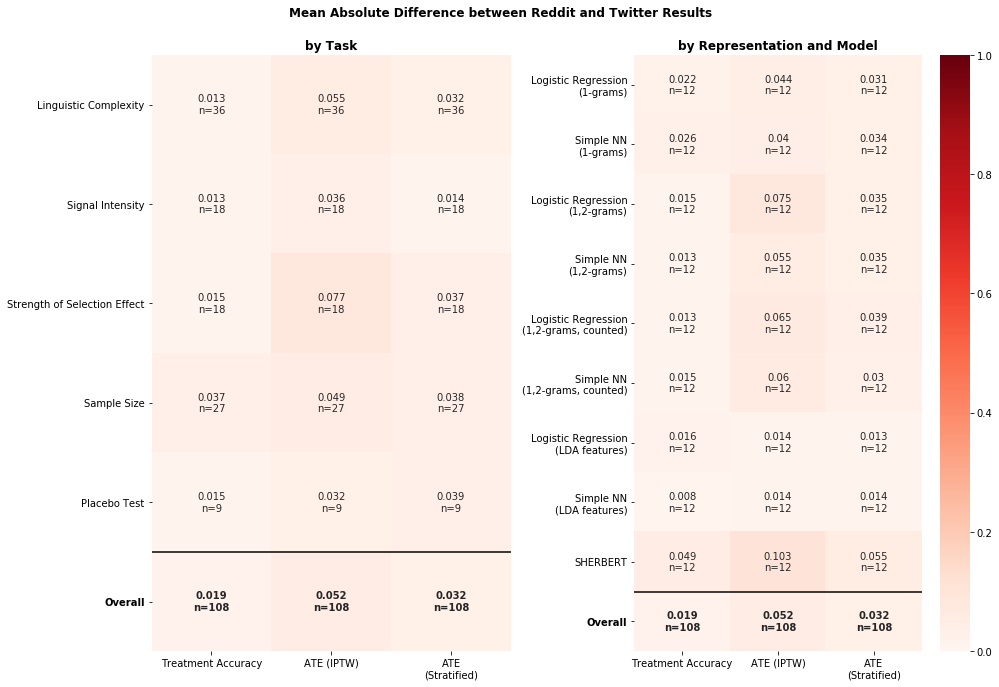

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(14,10))

for ax, sim, n, rang in zip(axs, (tasks_sim, models_sim), (tasks_n, models_n), (tasks_range, models_range)):
    sns.heatmap(sim, annot=False, cbar=False if sim.index.name=='Task' else True,  ax=ax, fmt='.3f', annot_kws={'va':'bottom'}, **color_config) # if adding colorbar, do so here
    
    #annotations = sim.round(3).astype(str) + '\n' + 'n='+ n.astype(str) + '\nrange='+ rang.round(3).astype(str)
    annotations = sim.round(3).astype(str) + '\n' + 'n='+ n.astype(str)
    
    # annotate twice, once for the main cells, and once for boldface overall values
    overall_annotations = annotations.loc['Overall',:].copy()
    annotations.loc['Overall',:] = 3*['']
    sns.heatmap(sim, annot=annotations, cbar=False, ax=ax, fmt='', **color_config )
    
    for r in annotations.index: annotations.loc[r,:] = '' 
    annotations.loc['Overall',:] = overall_annotations
    sns.heatmap(sim, annot=annotations, cbar=False, ax=ax, fmt='', annot_kws={'weight': 'bold'}, **color_config )
    
    # line to divide off Overall
    ax.hlines(len(sim) - 1, *ax.get_xlim())
    
    # make overall Y tick label bold
    ax.get_yticklabels()[-1].set_weight('bold')
    
    # title
    ax.set_title(f'by {sim.index.name}', weight='bold')
    ax.yaxis.label.set_visible(False)
    
fig.suptitle(f'{func_name} between Reddit and Twitter Results', weight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figs/twitter_comparison.pdf')
plt.show()